In [420]:
from dataclasses import dataclass, field
from pathlib import Path
from typing import Optional, Dict, List, Tuple, Set, Callable, Any
import numpy as np
import pandas as pd
import timm
import torch
from huggingface_hub import hf_hub_download
from huggingface_hub.utils import HfHubHTTPError
from PIL import Image
from simple_parsing import field as sp_field
from simple_parsing import parse_known_args
from timm.data import create_transform, resolve_data_config
from torch import Tensor, nn
from torch.nn import functional as F
import glob
import os
import json
from wdv3_timm import load_labels_hf, pil_ensure_rgb, pil_pad_square, get_tags, LabelData, MODEL_REPO_MAP
import safetensors.torch

# Import YOLO
from ultralytics import YOLO


@dataclass
class DetectorConfig:
    name: str
    model_path: str
    confidence: float = 0.25  # Confedence для определения областей
    classes: List[int] = None # Классы определяемые моделью, если может в несколько
    remove_tags_from_full: List[str] = None # Для удаления тегов с предсказания с полной картинки при использовании этой модели
    remove_tags_from_region: List[str] = None # Удаление тегов из предсказаний в области определенной этой моделью
    add_tags_to_region: Dict[str, float] = None # Добавляет теги в этот регион
    exclude_from_region: List[str] = None 
    specific_excluded_tags: List[str] = None
    region_gen_threshold: Optional[float] = None  # Порог для общих тегов в регионах
    region_char_threshold: Optional[float] = None  # Порог для тегов персонажей в регионах
    
    def __post_init__(self):
        if self.classes is None:
            self.classes = [0]
        if self.remove_tags_from_full is None:
            self.remove_tags_from_full = []
        if self.remove_tags_from_region is None:
            self.remove_tags_from_region = []
        if self.add_tags_to_region is None:
            self.add_tags_to_region = {}
        if self.exclude_from_region is None:
            self.exclude_from_region = []
        if self.specific_excluded_tags is None:
            self.specific_excluded_tags = []


@dataclass
class ScriptOptions:
    ImageFolder: Path = sp_field(positional=True)
    model: str = sp_field(default="vit")
    gen_threshold: float = sp_field(default=0.35)
    char_threshold: float = sp_field(default=0.75)
    batch: int = sp_field(default=1)
    recursive: bool = sp_field(default=False)
    model_folder: Path = sp_field(default="./models/taggers/")  # Для моделей тегирования
    yolo_model_dir: Path = sp_field(default="./models/yolo/")    # Для YOLO моделей
    detectors_config: str = sp_field(default="detectors.json")
    output_file: str = sp_field(default="results.json")


def ensure_model_folder(folder_path: Path) -> Path:
    """Создает папку для моделей, если она не существует."""
    if not folder_path.exists():
        print(f"Создание папки для моделей: {folder_path}")
        folder_path.mkdir(parents=True, exist_ok=True)
    return folder_path


def download_model_files(repo_id: str, model_folder: Path) -> Dict[str, Path]:
    """Загружает файлы модели в локальную папку."""
    # Создаем подпапку для конкретной модели (например models/wd-vit-tagger-v3)
    model_name = repo_id.split('/')[-1]
    model_specific_folder = model_folder / model_name
    ensure_model_folder(model_specific_folder)
    
    # Файлы, которые нужно загрузить
    files_to_download = [
        "pytorch_model.bin",
        "config.json",
        "model.safetensors",  # Если используется safetensors
        "selected_tags.csv",  # Для тегов
    ]
    
    downloaded_files = {}
    for file in files_to_download:
        try:
            local_file_path = model_specific_folder / file
            # Если файл уже существует, пропускаем загрузку
            if local_file_path.exists():
                print(f"Файл {file} уже существует в {model_specific_folder}")
                downloaded_files[file] = local_file_path
                continue
                
            # Загружаем файл, если он не существует
            downloaded_file = hf_hub_download(
                repo_id=repo_id,
                filename=file,
                local_dir=str(model_specific_folder),
                local_files_only=False
            )
            downloaded_files[file] = Path(downloaded_file)
            print(f"Загружен файл: {downloaded_file}")
        except HfHubHTTPError as e:
            print(f"Не удалось загрузить {file}: {e}")
            # Некоторые файлы могут не существовать, это нормально
            continue
    
    return downloaded_files


def load_model_local_or_remote(repo_id: str, model_folder: Path) -> nn.Module:
    model_name = repo_id.split('/')[-1]
    model_specific_folder = model_folder / model_name
    model = timm.create_model("hf-hub:" + repo_id).eval()
    
    local_safetensors_path = model_specific_folder / "model.safetensors"
    
    if local_safetensors_path.exists():
        print(f"Loading model from {local_safetensors_path} using safetensors")
        state_dict = safetensors.torch.load_file(local_safetensors_path)
    else:
        print(f"Loading model from Hugging Face Hub for {repo_id}...")
        state_dict = timm.models.load_state_dict_from_hf(repo_id)
        ensure_model_folder(model_specific_folder)
        local_save_path = model_specific_folder / "model.safetensors"
        print(f"Saving model to {local_save_path} using safetensors")
        safetensors.torch.save_file(state_dict, local_save_path)
        state_dict = safetensors.torch.load_file(local_save_path)
    
    model.load_state_dict(state_dict)
    return model


def load_labels_local_or_remote(repo_id: str, model_folder: Path) -> LabelData:
    """Загружает теги из локальной папки или с Hugging Face Hub."""
    model_name = repo_id.split('/')[-1]
    model_specific_folder = model_folder / model_name
    local_tags_path = model_specific_folder / "selected_tags.csv"
    
    if local_tags_path.exists():
        print(f"Загрузка тегов из локального файла: {local_tags_path}")
        try:
            # Используем возможность передачи пути к CSV файлу
            # Адаптируем для локального использования
            df: pd.DataFrame = pd.read_csv(local_tags_path, usecols=["name", "category"])
            tag_data = LabelData(
                names=df["name"].tolist(),
                rating=list(np.where(df["category"] == 9)[0]),
                general=list(np.where(df["category"] == 0)[0]),
                character=list(np.where(df["category"] == 4)[0]),
            )
            return tag_data
        except Exception as e:
            print(f"Ошибка при загрузке локальных тегов: {e}")
            print("Попытка загрузки из Hugging Face Hub...")
    
    # Если локальных тегов нет или загрузка не удалась, загружаем из Hugging Face Hub
    print(f"Загрузка тегов из Hugging Face Hub для {repo_id}...")
    labels = load_labels_hf(repo_id=repo_id)
    
    # Если папка для модели существует, но CSV файла нет, можно скачать его
    # через hf_hub_download и сохранить локально
    if model_specific_folder.exists() and not local_tags_path.exists():
        try:
            hf_hub_download(
                repo_id=repo_id, 
                filename="selected_tags.csv", 
                local_dir=str(model_specific_folder),
                local_files_only=False
            )
            print(f"Файл тегов сохранен локально в {local_tags_path}")
        except Exception as e:
            print(f"Ошибка при сохранении файла тегов локально: {e}")
    
    return labels


def load_detectors_config(config_path: str) -> List[DetectorConfig]:
    if not os.path.exists(config_path):
        print(f"Файл конфигурации детекторов не найден: {config_path}")
        print("YOLO-детекторы не будут использоваться")
        return []

    try:
        with open(config_path, 'r', encoding='utf-8') as f:
            config_data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Ошибка в формате конфигурационного файла: {e}")
        return []

    detectors = []
    for item in config_data:
        try:
            detector = DetectorConfig(
                name=item["name"],
                model_path=item["model_path"],
                confidence=item.get("confidence", 0.25),
                classes=item.get("classes", [0]),
                remove_tags_from_full=item.get("remove_tags_from_full", []),
                remove_tags_from_region=item.get("remove_tags_from_region", []),
                add_tags_to_region=item.get("add_tags_to_region", {}),
                exclude_from_region=item.get("exclude_from_region", []),
                specific_excluded_tags=item.get("specific_excluded_tags", []),
                region_gen_threshold=item.get("region_gen_threshold"),
                region_char_threshold=item.get("region_char_threshold")
            )
            detectors.append(detector)
        except KeyError as e:
            print(f"Ошибка в конфигурации детектора: отсутствует обязательное поле {e}")
        except Exception as e:
            print(f"Ошибка обработки конфигурации детектора: {e}")

    return detectors


def extract_regions_with_detector(img_path: str, detector: DetectorConfig, yolo_model: YOLO) -> List[Tuple[Image.Image, List[float], str]]:
    """
    Использует YOLO для детектирования объектов и вырезает области в исходном разрешении.
    
    Args:
        img_path: Путь к изображению
        detector: Конфигурация детектора
        yolo_model: Загруженная модель YOLO
        
    Returns:
        List of tuples (cropped_image, bbox, detector_name)
    """
    # Загрузка изображения
    img = Image.open(img_path)
    
    # Запускаем YOLO детекцию с параметрами из конфигурации детектора
    results = yolo_model(img_path, conf=detector.confidence, classes=detector.classes)
    
    # Извлекаем обнаруженные области
    regions = []
    
    # Проверяем, есть ли какие-либо результаты
    if len(results) > 0 and hasattr(results[0], 'boxes'):
        # Извлекаем боксы из результатов YOLO
        for result in results:
            boxes = result.boxes
            for box in boxes:
                # Получаем координаты бокса
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                
                # Обрезаем изображение по координатам бокса
                cropped_img = img.crop((x1, y1, x2, y2))
                
                # Добавляем обрезанное изображение, координаты и имя детектора в список
                regions.append((cropped_img, [x1, y1, x2, y2], detector.name))
    
    return regions


def process_tags(tags_dict: Dict[str, float], tags_to_remove: List[str]) -> Dict[str, float]:
    """
    Удаляет указанные теги из словаря тегов.
    
    Args:
        tags_dict: Словарь тегов и их уверенностей
        tags_to_remove: Список тегов для удаления
        
    Returns:
        Обновленный словарь тегов
    """
    return {tag: conf for tag, conf in tags_dict.items() if tag not in tags_to_remove}


def tag_image(img: Image.Image, model: nn.Module, transform: Callable, labels: LabelData, 
             gen_threshold: float, char_threshold: float, torch_device: torch.device) -> Dict:
    """
    Тегирует изображение с помощью модели.
    
    Args:
        img: Изображение для тегирования
        model: Модель для тегирования
        transform: Функция преобразования
        labels: Данные о тегах
        gen_threshold: Порог для общих тегов
        char_threshold: Порог для тегов персонажей
        torch_device: Устройство для вычислений
        
    Returns:
        Dict с результатами тегирования
    """
    # Обработка изображения
    img = pil_ensure_rgb(img)
    img_padded = pil_pad_square(img)
    input_tensor = transform(img_padded)
    input_tensor = input_tensor[[2, 1, 0], :, :]  # RGB -> BGR
    
    # Инференс
    with torch.inference_mode():
        input_batch = input_tensor.unsqueeze(0).to(torch_device)
        output = model(input_batch)
        output = F.sigmoid(output).to("cpu")
    
    # Получаем теги
    caption, taglist, ratings, character, general = get_tags(
        probs=output[0],
        labels=labels,
        gen_threshold=gen_threshold,
        char_threshold=char_threshold,
    )
    
    return {
        "caption": caption,
        "taglist": taglist,
        "ratings": ratings,
        "character": character,
        "general": general,
    }


def process_image_with_multiple_detectors(
    img_path: str, 
    tagger_model: nn.Module, 
    transform: Callable, 
    labels: LabelData,
    detectors: List[DetectorConfig],
    yolo_models: Dict[str, YOLO],
    gen_threshold: float,  # Из ScriptOptions
    char_threshold: float,  # Из ScriptOptions
    torch_device: torch.device
) -> Dict:
    img_full = Image.open(img_path)
    full_image_tags = tag_image(
        img_full, tagger_model, transform, labels, 
        gen_threshold, char_threshold, torch_device
    )
    
    all_detector_results = {}
    final_full_image_tags = {
        "caption": full_image_tags["caption"],
        "taglist": full_image_tags["taglist"],
        "ratings": full_image_tags["ratings"],
        "character": full_image_tags["character"],
        "general": full_image_tags["general"]
    }

    for detector in detectors:
        detector_name = detector.name
        yolo_model = yolo_models.get(detector.model_path)
        if yolo_model is None:
            continue
        
        # Используем пороги из DetectorConfig или из ScriptOptions
        region_gen_threshold = detector.region_gen_threshold if detector.region_gen_threshold is not None else gen_threshold
        region_char_threshold = detector.region_char_threshold if detector.region_char_threshold is not None else char_threshold
        
        regions = extract_regions_with_detector(img_path, detector, yolo_model)
        detector_results = []
        
        for idx, (region_img, bbox, _) in enumerate(regions):
            region_tags = tag_image(
                region_img, tagger_model, transform, labels,
                region_gen_threshold, region_char_threshold, torch_device  # Используем пороги для регионов
            )
            region_tags["general"] = process_tags(region_tags["general"], detector.remove_tags_from_region)
            region_tags["character"] = process_tags(region_tags["character"], detector.remove_tags_from_region)
            
            for tag, conf in detector.add_tags_to_region.items():
                if tag in region_tags["character"] or any(tag == labels.names[i] for i in labels.character):
                    region_tags["character"][tag] = conf
                else:
                    region_tags["general"][tag] = conf
            
            combined_tags = list(region_tags["general"].keys()) + list(region_tags["character"].keys())
            region_tags["taglist"] = ", ".join(combined_tags)
            
            detector_results.append({
                "region_id": idx,
                "bbox": bbox,
                "caption": region_tags["caption"],
                "taglist": region_tags["taglist"],
                "ratings": region_tags["ratings"],
                "character": region_tags["character"],
                "general": region_tags["general"],
            })
        
        all_detector_results[detector_name] = detector_results
    
    combined_tags = list(final_full_image_tags["general"].keys()) + list(final_full_image_tags["character"].keys())
    final_full_image_tags["taglist"] = ", ".join(
    tag.replace("_", " ") 
    for tag in combined_tags
    )
    
    return {
        "image_path": img_path,
        "full_image": final_full_image_tags,
        "detectors": all_detector_results
    }


def merge_tags_from_regions(image_result: Dict, detectors: List[DetectorConfig]) -> Dict:
    # Теги из полной картинки
    full_general = image_result["full_image"]["general"]
    full_character = image_result["full_image"]["character"]
    full_tags_set = set(full_general.keys()) | set(full_character.keys())
    
    # Глобальный список запрещённых тегов
    # Удаляет теги которые появились в обнаруженой области если они есть
    #Для артефактов приближения определяя данные теги из полного изображения
    GLOBAL_EXCLUDED_REGION_TAGS = {"close-up", "cowboy_shot", "portrait", "upper_body", 
                                   "full_body", "eye_focus", "1girl", "2girls", "3girls", "4girls", "5girls", "6+girls", 
                                   "solo", "solo_focus", "1boy", "2boys", "3boys", "4boys", "5boys", "6+boys", "male_focus", 
                                   "other_focus",  "1other", "2others", "3others", "4others", "5others", "6+others", 
                                   "ass_focus",  "animal_focus", "foot_focus", "text_focus", " hip_focus", " vehicle_focus",
                                   "food_focus", "mecha_focus", "pokemon_focus", "reflection_focus",  "breast_focus", 
                                   "back_focus", "hand_focus", "object_focus", "crotch_focus", "pectoral_focus", "weapon_focus", 
                                   "armpit_focus", "monster_focus", "pussy_focus", "creature_focus", "flower_focus", "hair_focus",
                                   "footwear_focus", "navel_focus", "sky_focus", "plant_focus", "thigh_focus", "mouth_focus", "leg_focus",
                                   "ear_focus", "kanji_focus", "neck_focus", "penis_focus"}
    
    # Инициализируем результирующие теги
    merged_general = {}
    merged_character = full_character.copy()  # Пока из полной картинки
    merged_tags = []  # Единый список тегов для caption и taglist

    # Проходим по всем детекторам и их областям
    for detector_name, regions in image_result["detectors"].items():
        detector_config = next(d for d in detectors if d.name == detector_name)
        
        # Теги для исключения из полной картинки
        exclude_from_full = set(detector_config.remove_tags_from_full) | set(detector_config.specific_excluded_tags)
        
        for region in regions:
            region_general = region["general"]
            region_character = region["character"]
            
            # Фильтруем теги области
            filtered_general = {}
            for tag, conf in region_general.items():
                if tag in detector_config.remove_tags_from_region:
                    continue
                if (tag in detector_config.exclude_from_region or tag in GLOBAL_EXCLUDED_REGION_TAGS) and tag not in full_tags_set:
                    continue
                filtered_general[tag] = conf
            
            # Обновляем merged_general
            for tag, conf in filtered_general.items():
                if tag not in merged_general or conf > merged_general[tag]:
                    merged_general[tag] = conf
            
            # Обновляем merged_character
            for tag, conf in region_character.items():
                if tag not in merged_character or conf > merged_character[tag]:
                    merged_character[tag] = conf
            
            # Собираем теги из области в единый список
            region_tags = list(filtered_general.keys()) + list(region_character.keys())
            merged_tags.extend(region_tags)
    
    # Добавляем теги из полной картинки, исключая указанные
    for tag, conf in full_general.items():
        if tag not in exclude_from_full:
            if tag not in merged_general or conf > merged_general[tag]:
                merged_general[tag] = conf
                merged_tags.append(tag)

    # Формируем caption и taglist из одного источника
    unique_merged_tags = sorted(set(merged_tags))  # Убираем дубликаты и сортируем
    merged_caption = ", ".join(unique_merged_tags)  # С подчёркиваниями
    merged_taglist = ", ".join(tag.replace("_", " ") for tag in unique_merged_tags)  # Без подчёркиваний

    return {
        "caption": merged_caption,
        "taglist": merged_taglist,
        "general": merged_general,
        "character": merged_character,
        "ratings": image_result["full_image"]["ratings"].copy()
    }


# Создаем кастомный энкодер для обработки numpy.float32
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

# Исправленная функция сохранения в JSON
def save_results_to_json(results, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False, cls=NumpyEncoder)
    print(f"Результаты сохранены в {output_file}")


def BatchTagging(opts: ScriptOptions):
    if opts.model not in MODEL_REPO_MAP:
        print(f"Доступные модели: {list(MODEL_REPO_MAP.keys())}")
        raise ValueError(f"Неизвестная модель: {opts.model}")
    
    repo_id = MODEL_REPO_MAP[opts.model]
    image_folder = Path(opts.ImageFolder).resolve()
    if not image_folder.is_dir():
        raise FileNotFoundError(f"Директория не найдена: {image_folder}")
    
    # Создаем папку для моделей, если она не существует
    model_folder = ensure_model_folder(Path(opts.model_folder))
    
    # Загружаем или скачиваем файлы модели
    download_model_files(repo_id, model_folder)
    
    # Загружаем модель из локальной папки или из Hub
    print(f"Загрузка модели тегирования '{opts.model}' из '{repo_id}'...")
    tagger_model = load_model_local_or_remote(repo_id, model_folder)
    
    # Загружаем теги из локальной папки или из Hub
    print("Загрузка списка тегов...")
    labels = load_labels_local_or_remote(repo_id, model_folder)
    
    print("Создание трансформации данных...")
    transform = create_transform(**resolve_data_config(tagger_model.pretrained_cfg, model=tagger_model))
    
    # Загружаем конфигурацию детекторов
    print(f"Загрузка конфигурации детекторов из {opts.detectors_config}...")
    detectors = load_detectors_config(opts.detectors_config)
    
    # Загружаем все уникальные модели YOLO
    yolo_models = {}
    for detector in detectors:
        if detector.model_path not in yolo_models:
            print(f"Загрузка модели YOLO {detector.model_path}...")
            try:
                yolo_models[detector.model_path] = YOLO(detector.model_path)
            except Exception as e:
                print(f"Ошибка загрузки модели YOLO {detector.model_path}: {e}")
                print(f"Детектор {detector.name} будет пропущен")
    
    # Получаем список изображений
    if opts.recursive:
        image_files = list(image_folder.rglob("*.jpg")) + list(image_folder.rglob("*.jpeg")) + list(image_folder.rglob("*.png"))
    else:
        image_files = list(image_folder.glob("*.jpg")) + list(image_folder.glob("*.jpeg")) + list(image_folder.glob("*.png"))
    
    if not image_files:
        print("Изображения не найдены в указанной директории.")
        return
    
    torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tagger_model = tagger_model.to(torch_device)
    
    all_results = []
    all_merged_results = []
    total_images = len(image_files)
    
    print(f"Всего изображений для обработки: {total_images}")
    
    for i, img_path in enumerate(image_files):
        print(f"\nОбработка изображения {i+1}/{total_images}: {img_path}")
        
        # Обрабатываем изображение со всеми детекторами
        result = process_image_with_multiple_detectors(
            str(img_path),
            tagger_model,
            transform,
            labels,
            detectors,
            yolo_models,
            opts.gen_threshold,
            opts.char_threshold,
            torch_device
        )
        
        if result:
            all_results.append(result)
            
            # Объединяем теги из всех источников
            merged_tags = merge_tags_from_regions(result, detectors)
            all_merged_results.append({
                "image_path": result["image_path"],
                "merged_tags": merged_tags
            })
            
            # Выводим информацию о результатах
            print("--------")
            print(f"Путь к изображению: {result['image_path']}")
            print("\nРезультаты для полного изображения:")
            print(f"Описание: {result['full_image']['caption']}")
            print(f"Теги: {result['full_image']['taglist']}")
            
            # Выводим информацию о найденных областях для каждого детектора
            for detector_name, regions in result["detectors"].items():
                if regions:
                    print(f"\nДетектор {detector_name}: найдено областей: {len(regions)}")
                    for region in regions:
                        print(f"  Область {region['region_id']+1}, координаты: {region['bbox']}")
                        print(f"  Описание: {region['caption']}")
                        print(f"  Теги: {region['taglist']}")
                else:
                    print(f"\nДетектор {detector_name}: областей не найдено")
            
            # Выводим объединенные теги
            print("\nОбъединенные теги:")
            print(f"Описание: {merged_tags['caption']}")
            print(f"Теги: {merged_tags['taglist']}")
            print("--------")
    
    print(f"\nОбработка завершена. Обработано изображений: {len(all_results)}/{total_images}")
    
    # Сохраняем результаты в файл
    if opts.output_file:
        save_results_to_json(all_results, opts.output_file)
        
        # Также сохраняем объединенные результаты
        merged_output = os.path.splitext(opts.output_file)[0] + "_merged" + os.path.splitext(opts.output_file)[1]
        save_results_to_json(all_merged_results, merged_output)
    
    return all_results, all_merged_results



# Пример конфига для настройки yolo моделей и обработки рещультата областей
EXAMPLE_DETECTORS_CONFIG = [
    {
        "name": "person_detector",
        "model_path": "yolov8n.pt",
        "confidence": 0.25,
        "classes": [0],
        "remove_tags_from_full": ["1girl", "1boy"],
        "remove_tags_from_region": ["multiple views"],
        "add_tags_to_region": {"person": 1.0},
        "exclude_from_region": ["close-up", "cowboy_shot", "full_body"],
        "specific_excluded_tags": [],
        "region_gen_threshold": 0.4,  # Более строгий для регионов
        "region_char_threshold": 0.8
    },
    {
        "name": "face_detector",
        "model_path": "yolov8n-face.pt",
        "confidence": 0.3,
        "classes": [0],
        "remove_tags_from_full": ["face"],
        "remove_tags_from_region": ["full body"],
        "add_tags_to_region": {"face": 1.0},
        "exclude_from_region": ["1girl", "portrait", "upper_body"],
        "specific_excluded_tags": ["blue_eyes", "green_eyes", "yellow_eyes", "smile"],
        "region_gen_threshold": 0.5,  # Ещё строже для лиц
        "region_char_threshold": 0.85
    },
    {
        "name": "building_detector",
        "model_path": "yolov8n-buildings.pt",
        "confidence": 0.25,
        "classes": [67],
        "remove_tags_from_full": ["building"],
        "remove_tags_from_region": ["multiple views"],
        "add_tags_to_region": {"building": 1.0},
        "exclude_from_region": ["close-up", "portrait"],
        "specific_excluded_tags": ["window", "door"],
        "region_gen_threshold": 0.45,  # Пример для зданий
        "region_char_threshold": 0.75  # Оставим как у полной картинки
    }
]

In [436]:
params= ScriptOptions(
    os.path.join(os.getcwd(), 'TestPic'),
    'big',
    0.35,
    0.75,
    2,
    False
)



In [438]:
result=BatchTagging(params)

Создание папки для моделей: models\taggers\wd-eva02-large-tagger-v3
Не удалось загрузить pytorch_model.bin: 404 Client Error. (Request ID: Root=1-67c4f67a-550b2229418a70e520f5c134;876f0927-f3e0-4f97-a3cd-36b4f25a8b50)

Entry Not Found for url: https://huggingface.co/SmilingWolf/wd-eva02-large-tagger-v3/resolve/main/pytorch_model.bin.
Загружен файл: models\taggers\wd-eva02-large-tagger-v3\config.json
Загружен файл: models\taggers\wd-eva02-large-tagger-v3\model.safetensors


selected_tags.csv:   0%|          | 0.00/308k [00:00<?, ?B/s]

Загружен файл: models\taggers\wd-eva02-large-tagger-v3\selected_tags.csv
Загрузка модели тегирования 'big' из 'SmilingWolf/wd-eva02-large-tagger-v3'...
Loading model from models\taggers\wd-eva02-large-tagger-v3\model.safetensors using safetensors
Загрузка списка тегов...
Загрузка тегов из локального файла: models\taggers\wd-eva02-large-tagger-v3\selected_tags.csv
Создание трансформации данных...
Загрузка конфигурации детекторов из detectors.json...
Загрузка модели YOLO yolov8n.pt...
Загрузка модели YOLO yolov8n-face.pt...
Ошибка загрузки модели YOLO yolov8n-face.pt: [Errno 2] No such file or directory: 'yolov8n-face.pt'
Детектор face_detector будет пропущен
Загрузка модели YOLO yolov8n-buildings.pt...
Ошибка загрузки модели YOLO yolov8n-buildings.pt: [Errno 2] No such file or directory: 'yolov8n-buildings.pt'
Детектор building_detector будет пропущен
Всего изображений для обработки: 4

Обработка изображения 1/4: C:\Users\liali\YoloWdTagger\wdv3-timm\TestPic\test1.png

image 1/1 C:\User

In [440]:
# result[0][x] - теги по областям, для общей области, путь до изображения, какие детекторы и box для них Для Изображения X
# result[1][x] - обьедененые теги + путь до изображения X
print(result[1][0].keys())
print()
print(result[0][0].keys())
print()
print(result[1][0]['merged_tags'].keys())

dict_keys(['image_path', 'merged_tags'])

dict_keys(['image_path', 'full_image', 'detectors'])

dict_keys(['caption', 'taglist', 'general', 'character', 'ratings'])


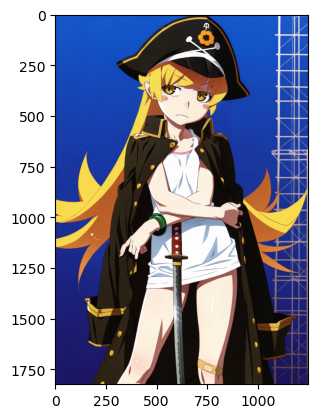

In [442]:
import matplotlib.pyplot as plt

plt.imshow(Image.open(result[1][1]['image_path']))

In [444]:
print(result[1][1]['merged_tags']['caption'])
print()
print(result[1][1]['merged_tags']['taglist'])

1girl, bandaid, bandaid_on_knee, bandaid_on_leg, bangle, black_headwear, blonde_hair, blue_background, blush_stickers, bracelet, closed_mouth, coat, collarbone, contrapposto, crossed_arms, dress, fang, fang_out, feet_out_of_frame, flat_chest, frown, hat, jacket, jacket_on_shoulders, jewelry, jolly_roger, katana, legs_apart, long_hair, looking_at_viewer, military_jacket, oshino_shinobu, peaked_cap, person, pirate_hat, planted, planted_sword, pointy_ears, shiny_skin, short_dress, simple_background, skin_fang, skull_and_crossbones, solo, standing, sword, very_long_hair, weapon, white_dress, yellow_eyes

1girl, bandaid, bandaid on knee, bandaid on leg, bangle, black headwear, blonde hair, blue background, blush stickers, bracelet, closed mouth, coat, collarbone, contrapposto, crossed arms, dress, fang, fang out, feet out of frame, flat chest, frown, hat, jacket, jacket on shoulders, jewelry, jolly roger, katana, legs apart, long hair, looking at viewer, military jacket, oshino shinobu, pea

In [448]:
print(result[0][1]['full_image']['taglist'])
print()
print(result[1][1]['merged_tags']['taglist'])

1girl, hat, long hair, sword, solo, weapon, blonde hair, yellow eyes, blush stickers, bandaid, bandaid on knee, bandaid on leg, bracelet, dress, fang, jacket on shoulders, pirate hat, planted sword, jewelry, planted, blue background, katana, pointy ears, looking at viewer, standing, jacket, white dress, contrapposto, collarbone, very long hair, black headwear, closed mouth, crossed arms, frown, skull and crossbones, fang out, coat, bangle, jolly roger, short dress, feet out of frame, flat chest, military jacket, legs apart, skin fang, peaked cap, simple background, shiny skin, oshino shinobu

1girl, bandaid, bandaid on knee, bandaid on leg, bangle, black headwear, blonde hair, blue background, blush stickers, bracelet, closed mouth, coat, collarbone, contrapposto, crossed arms, dress, fang, fang out, feet out of frame, flat chest, frown, hat, jacket, jacket on shoulders, jewelry, jolly roger, katana, legs apart, long hair, looking at viewer, military jacket, oshino shinobu, peaked cap,